In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import os
%matplotlib inline
from PIL import Image

## Data Preparation

In [5]:
# Merging Data from files with pixel info of annotated images( adter wrangle_VIA_annotation)
w_3 = pd.read_csv(r"pixels_df_1.csv")
w_6_1= pd.read_csv(r"pixels_df_2.csv")
w_6_2 = pd.read_csv(r"pixels_df_3.csv")
# merge watershed folder 6
w_6 = pd.concat([w_6_1, w_6_2])

In [4]:
w_6.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,01/01/2019,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
1,1403,1266,192,177,218,01/01/2019,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
2,1403,1267,192,177,218,01/01/2019,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
3,1403,1268,190,178,218,01/01/2019,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
4,1403,1269,190,178,218,01/01/2019,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o


In [50]:
# merge watershed 6 and 3
merged = pd.concat([w_6,w_3])
merged = merged.drop_duplicates()
merged.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
1,1403,1266,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
2,1403,1267,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
3,1403,1268,190,178,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
4,1403,1269,190,178,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o


In [51]:
merged.shape

(10859075, 11)

In [17]:
# create date, time, week of the year, month and season columns to merged dataframe and save
# add year, week of the year, month, and season features to our data
from datetime import date, datetime

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]
def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

merged.date = pd.to_datetime(merged.date)
merged.time = pd.to_datetime(merged.time)
merged["year"] = merged.date.dt.year
merged["week"] =merged.date.dt.isocalendar().week
merged["month"] = merged.date.dt.month
merged["season"] = merged.date.apply(lambda x: get_season(x))
merged = pd.get_dummies(merged, columns=["season"], prefix=["season"] )

In [18]:
# fill missing temperature from previous row
merged.temperature = merged.temperature.fillna(method="ffill")
merged.dropna(inplace=True)

In [19]:
# save csv
merged.to_csv("merged.csv", index=False)

In [3]:
def pick_samples(df):
    '''
    pick samples from each class with defined approximate max class size
    '''
    sampled_df = df.head(1)
    max_class_size = 100
    for date in df.orig_name.unique():
        date_grouped = df[df.orig_name==date]
        nth = len(date_grouped)//max_class_size
        if nth==0:
            sampled_df = pd.concat([sampled_df,date_grouped])
        else:
            curr_group = date_grouped.iloc[::nth,:]
            sampled_df = pd.concat([sampled_df,curr_group])
    sampled_df.drop_duplicates(inplace=True)
    return sampled_df

In [21]:
# make sample data set from merged data
sample_merged = pick_samples(merged)
sample_merged = sample_merged.drop_duplicates()
sample_merged.shape

(34177, 17)

In [22]:
sample_merged.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class,year,week,month,season_autumn,season_spring,season_winter
0,1403,1265,192,177,218,2019-01-01,2022-07-19 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
161,1407,1294,186,175,215,2019-01-01,2022-07-19 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
322,1412,1290,194,183,223,2019-01-01,2022-07-19 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
483,1417,1286,188,180,219,2019-01-01,2022-07-19 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
644,1422,1282,184,178,216,2019-01-01,2022-07-19 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1


In [23]:
# save sample csv
sample_merged.to_csv("sample_merged.csv", index=False)

In [24]:
sample_merged.describe()

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter
count,34177.000000,34177.000000,34177.000000,34177.000000,34177.000000,34177.000000,34177.000000,34177.000000,34177.000000,34177.000000,34177.000000,34177.000000
mean,1229.445036,1729.152793,131.802645,121.492319,128.573573,36.054218,2018.982210,24.478012,6.108231,0.367352,0.106563,0.526085
std,376.840877,327.267989,78.526762,79.790394,93.315983,12.327167,0.678755,19.982641,4.593235,0.482091,0.308561,0.499326
min,47.000000,1234.000000,0.000000,0.000000,0.000000,12.000000,2018.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1037.000000,1439.000000,58.000000,47.000000,38.000000,28.000000,2019.000000,6.000000,2.000000,0.000000,0.000000,0.000000
50%,1268.000000,1608.000000,125.000000,110.000000,105.000000,33.000000,2019.000000,13.000000,4.000000,0.000000,0.000000,1.000000
75%,1489.000000,2074.000000,202.000000,194.000000,230.000000,43.000000,2019.000000,47.000000,11.000000,1.000000,0.000000,1.000000
max,1997.000000,2336.000000,255.000000,255.000000,255.000000,98.000000,2020.000000,52.000000,12.000000,1.000000,1.000000,1.000000


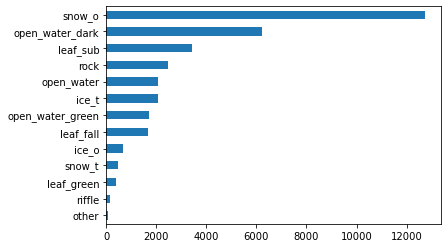

In [25]:
# distribution of classes in sample, indicative of the imbalanced distribution similar in watershed 3 and watershed 6
sample_merged["class"].value_counts().sort_values(ascending=True).plot(kind="barh");

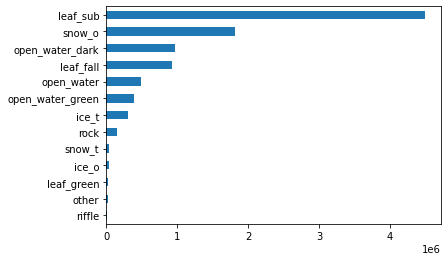

In [58]:
# watershed 6 distribution
w_6["class"].value_counts().sort_values(ascending=True).plot(kind="barh");

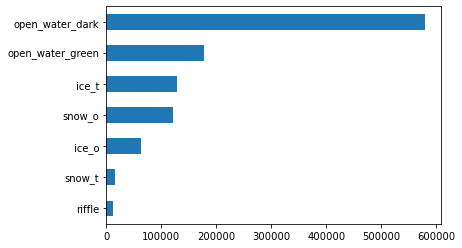

In [59]:
# watershed 3 distribution
w_3["class"].value_counts().sort_values(ascending=True).plot(kind="barh");

Imbalanced class is an issue. But we will train our model keeping the same distribution for now

## Train Random Forest Model

In [5]:
def split_fit_basic_report(df):
    """
    Split dataset into training and test, fit model using mostly default RCF parameters
    return model, prediction, feature_importances, X_train, X_test, y_train, y_test
    
    """
    X = df.drop('class',axis=1)
    y = df['class'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)
    rfc = RandomForestClassifier(random_state = 1)
    rfc.fit(X_train, y_train)
    # predict on test data
    rfc_pred = rfc.predict(X_test)
    print(classification_report(y_test,rfc_pred))
    feature_val = pd.DataFrame(rfc.feature_importances_, index = X_train.columns)
    print(feature_val.sort_values(0, ascending=False))
    return rfc, rfc_pred,feature_val,  X_train, X_test, y_train, y_test

def plot_cm(y_test, rfc_pred):
    """
    plot confusion matrix of model predictions
    """
    p,ax = plt.subplots(figsize=(30, 20))

    ConfusionMatrixDisplay.from_predictions(y_test, rfc_pred, ax=ax, colorbar=True)
    plt.show()


### Use features x and y coordinates, RGB values, Temperature

                  precision    recall  f1-score   support

           ice_o       0.94      0.85      0.90       191
           ice_t       0.82      0.80      0.81       516
       leaf_fall       0.92      0.82      0.87       365
      leaf_green       0.91      0.88      0.89        77
        leaf_sub       0.82      0.82      0.82       577
      open_water       0.80      0.79      0.80       412
 open_water_dark       0.84      0.93      0.88      1250
open_water_green       0.84      0.72      0.77       421
           other       1.00      0.29      0.45        17
          riffle       0.97      0.72      0.83        47
            rock       0.90      0.94      0.92       591
          snow_o       0.98      1.00      0.99      2383
          snow_t       0.92      0.64      0.76       133

        accuracy                           0.90      6980
       macro avg       0.90      0.79      0.82      6980
    weighted avg       0.90      0.90      0.89      6980

           

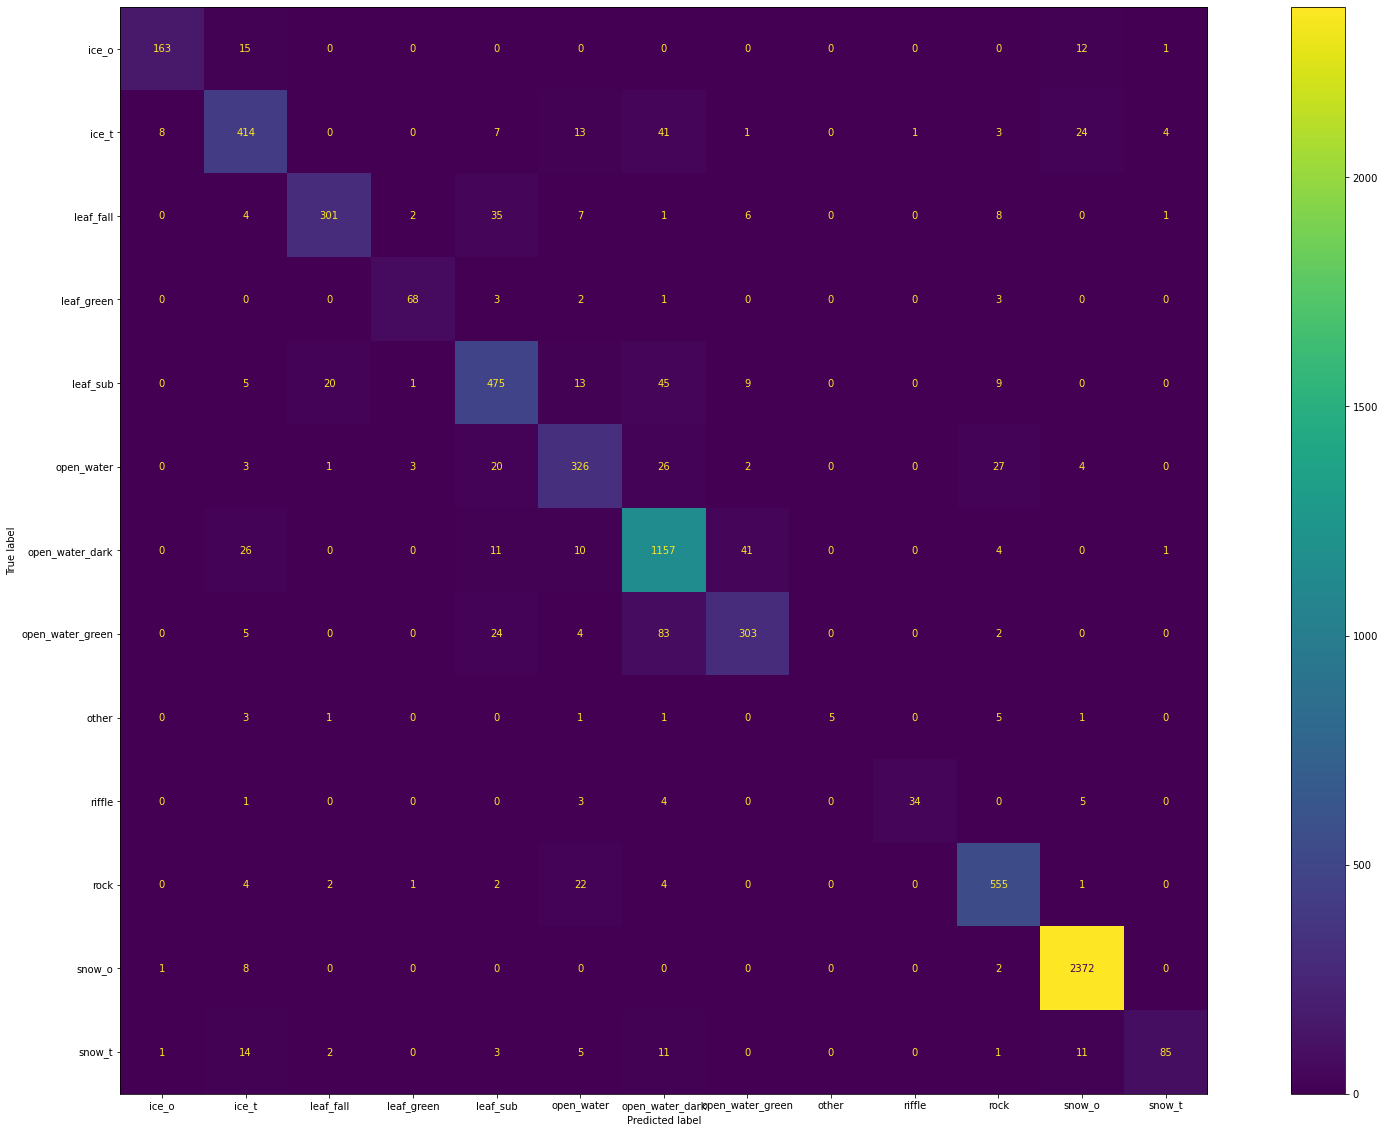

In [6]:
# using x,y,RGB, temp
train_merged = sample_merged[["x","y","R","G","B", "temperature", "class"]]
train_merged.dropna(inplace=True)
rfc, rfc_pred,feature_val,  X_train, X_test, y_train, y_test = split_fit_basic_report(train_merged)
plot_cm(y_test, rfc_pred)

Use grid search to select best estimators for this model and improve predictive performance

In [7]:
## Create Randomized search CV to find estimates closer to the best paramaters
# grid search create dict
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
n_cpus = os.cpu_count()
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 10, cv = 5,
                               random_state=42, n_jobs = n_cpus-1,
                               scoring = "accuracy")

In [8]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=63,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, scoring='accuracy')

In [9]:
# best parameters found using random search
rf_random.best_params_

{'n_estimators': 928,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': False}

In [43]:
# result of random search cv
# training error
print (rf_random.score(X_train, y_train))
# testing error
print(rf_random.score(X_test, y_test))

0.9885791477342503
0.8888252148997134


Building up on the results of randomized cv search, find better params using grid search cv


In [38]:
param_grid = {
    'n_estimators': np.linspace(900, 950, 10, dtype = int),
    'max_depth': [30, 40, 50, 60],
    'min_samples_split': [8, 10,12],
    'min_samples_leaf': [1, 2]
}
# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = False)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = n_cpus-1)


In [39]:
grid_rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=8, n_estimators=900;, score=0.877 total time= 1.0min
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=950;, score=0.874 total time= 1.1min
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=927;, score=0.878 total time= 1.1min
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=944;, score=0.872 total time= 1.3min
[CV 1/5] END max_depth=40, min_samples_leaf=1, min_samples_split=8, n_estimators=922;, score=0.865 total time= 1.2min
[CV 3/5] END max_depth=40, min_samples_leaf=1, min_samples_split=10, n_estimators=950;, score=0.872 total time= 1.0min
[CV 2/5] END max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=911;, score=0.879 total time=  47.6s
[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=8, n_estimators=922;, score=0.863 total ti

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(bootstrap=False,
                                              criterion='entropy'),
             n_jobs=63,
             param_grid={'max_depth': [30, 40, 50, 60],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': array([900, 905, 911, 916, 922, 927, 933, 938, 944, 950])},
             verbose=3)

In [47]:
# best estimators of grid search cv
best_rf_grid = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 950}

In [51]:
# results of grid search cv
# training error
print (grid_rf_search.score(X_train, y_train))
# testing error
print(grid_rf_search.score(X_test, y_test))

0.9988947562323468
0.8961318051575932


In [55]:
# feature importances of our input features
pd.DataFrame(best_rf_grid.feature_importances_, index = ["x","y","R","G","B","temperature"], columns=["%_imp"]).sort_values("%_imp", 
                                                                                                                           ascending=False)

,%_imp
B,0.291604
R,0.164986
y,0.163910
G,0.151743
temperature,0.113986
x,0.113770


### Final Model : Use Additional features - Year, Week of day, Season variables

                  precision    recall  f1-score   support

           ice_o       0.97      0.93      0.95       191
           ice_t       0.91      0.92      0.92       516
       leaf_fall       0.94      0.91      0.92       365
      leaf_green       0.96      0.95      0.95        77
        leaf_sub       0.90      0.95      0.92       577
      open_water       0.92      0.92      0.92       412
 open_water_dark       0.93      0.96      0.95      1250
open_water_green       0.92      0.83      0.88       421
           other       1.00      0.35      0.52        17
          riffle       0.91      0.87      0.89        47
            rock       0.96      0.96      0.96       591
          snow_o       0.99      1.00      1.00      2383
          snow_t       0.97      0.88      0.92       133

        accuracy                           0.95      6980
       macro avg       0.95      0.88      0.90      6980
    weighted avg       0.95      0.95      0.95      6980

           

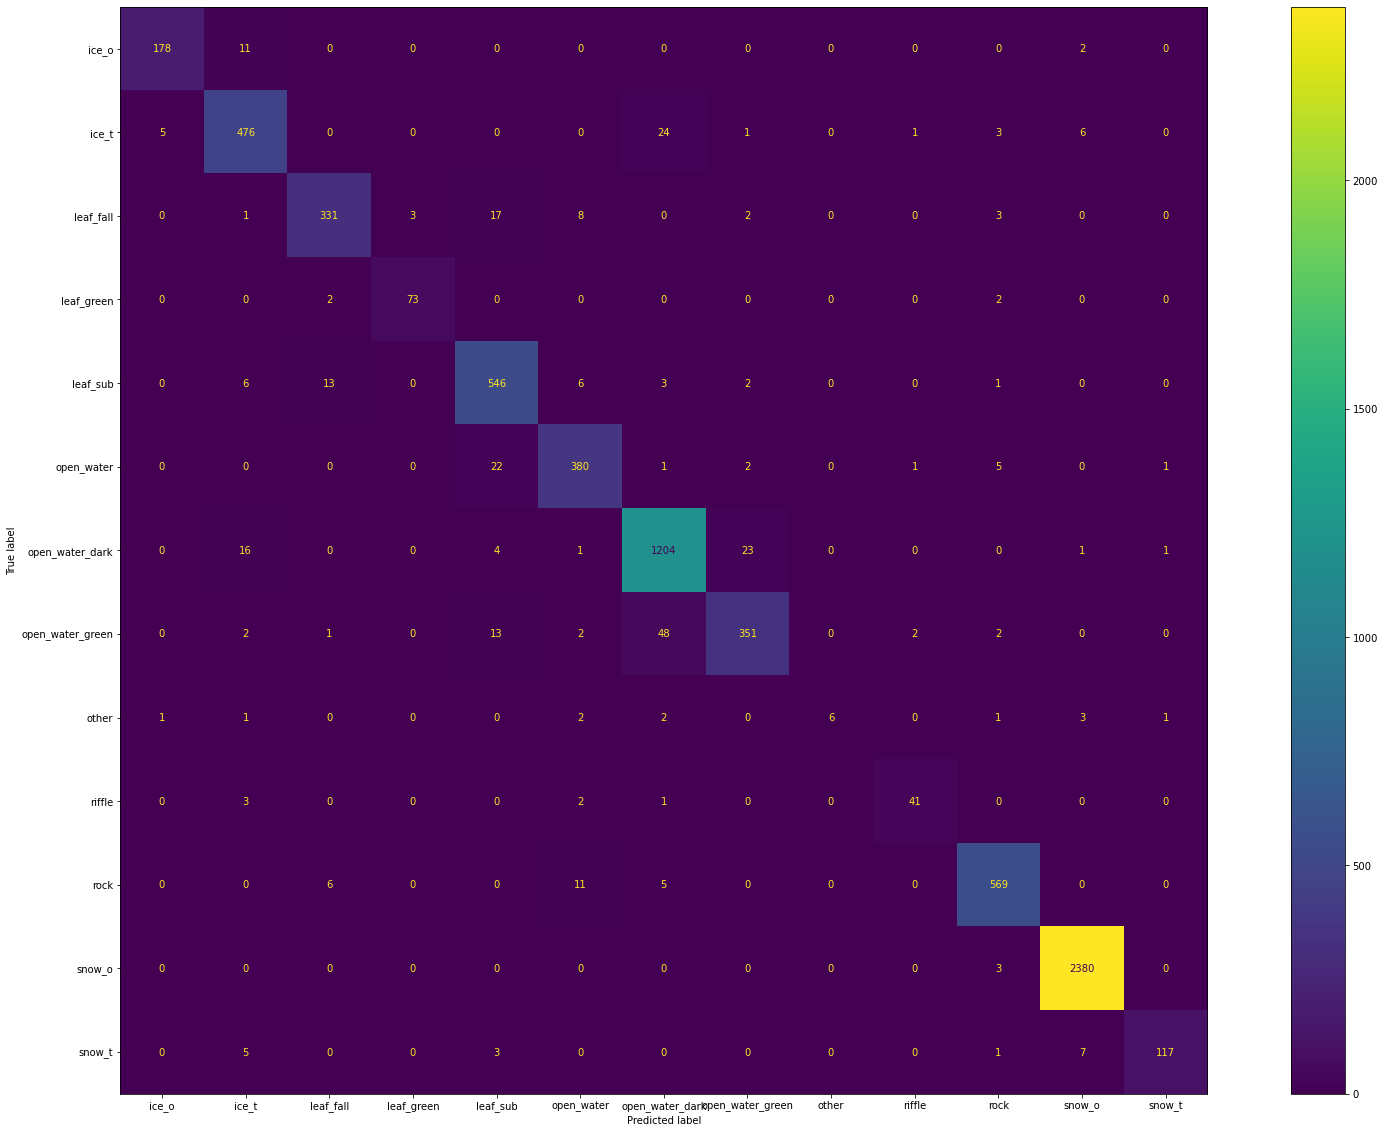

In [11]:
# model using RF default parameters
train_merged_2 = sample_merged[
    ['x', 'y', 'R', 'G', 'B',  'temperature', 'class', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter']]
train_merged_2.dropna(inplace=True)
rfc, rfc_pred,feature_val,  X_train, X_test, y_train, y_test = split_fit_basic_report(train_merged_2)
plot_cm(y_test, rfc_pred)

Use grid search to select best estimators and improve accuracy

In [12]:
# grid search create dict
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               random_state=42, n_jobs = n_cpus-1,
                               scoring = "accuracy")

In [80]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=75, min_samples_leaf=2, min_samples_split=20, n_estimators=307;, score=0.901 total time=   9.7s
[CV 3/5] END bootstrap=False, criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=30, n_estimators=1964;, score=0.912 total time= 1.3min
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=75, min_samples_leaf=2, min_samples_split=20, n_estimators=307;, score=0.905 total time=   9.4s
[CV 2/5] END bootstrap=False, criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=30, n_estimators=1964;, score=0.912 total time= 1.3min
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=307;, score=0.931 total time=   9.5s
[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=30, n_estimators=1964;, score=0.906 total time= 1.3min
[CV 1/

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=63,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, scoring='accuracy', verbose=3)

In [82]:
rf_random.best_params_

{'n_estimators': 2378,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 75,
 'criterion': 'entropy',
 'bootstrap': False}

In [ ]:
# training error
print (rf_random.score(X_train, y_train))
# testing error
print(rf_random.score(X_test, y_test))

In [13]:
# build up on the randomized cv search and find better params
param_grid = {
    'n_estimators': np.linspace(2300, 2400, 10, dtype = int),
    'max_depth': [30, 55, 75],
    'min_samples_split': [4,5],
    'min_samples_leaf': [1, 2]
}
# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = False)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = n_cpus-1)

In [14]:
grid_rf_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(bootstrap=False,
                                              criterion='entropy'),
             n_jobs=63,
             param_grid={'max_depth': [30, 55, 75], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [4, 5],
                         'n_estimators': array([2300, 2311, 2322, 2333, 2344, 2355, 2366, 2377, 2388, 2400])})

In [118]:
best_rf_grid_final = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 2355}

In [17]:
# training error
print (grid_rf_search.score(X_train, y_train))
# testing error
print(grid_rf_search.score(X_test, y_test))

1.0
0.9594555873925501


In [119]:
pd.DataFrame(best_rf_grid_final.feature_importances_, index = X_train.columns, columns=["%_imp"]).sort_values("%_imp",ascending=False)

,%_imp
B,0.212463
G,0.118422
R,0.116707
week,0.110567
y,0.102641
x,0.071066
year,0.071063
temperature,0.068147
month,0.062842
season_winter,0.037524


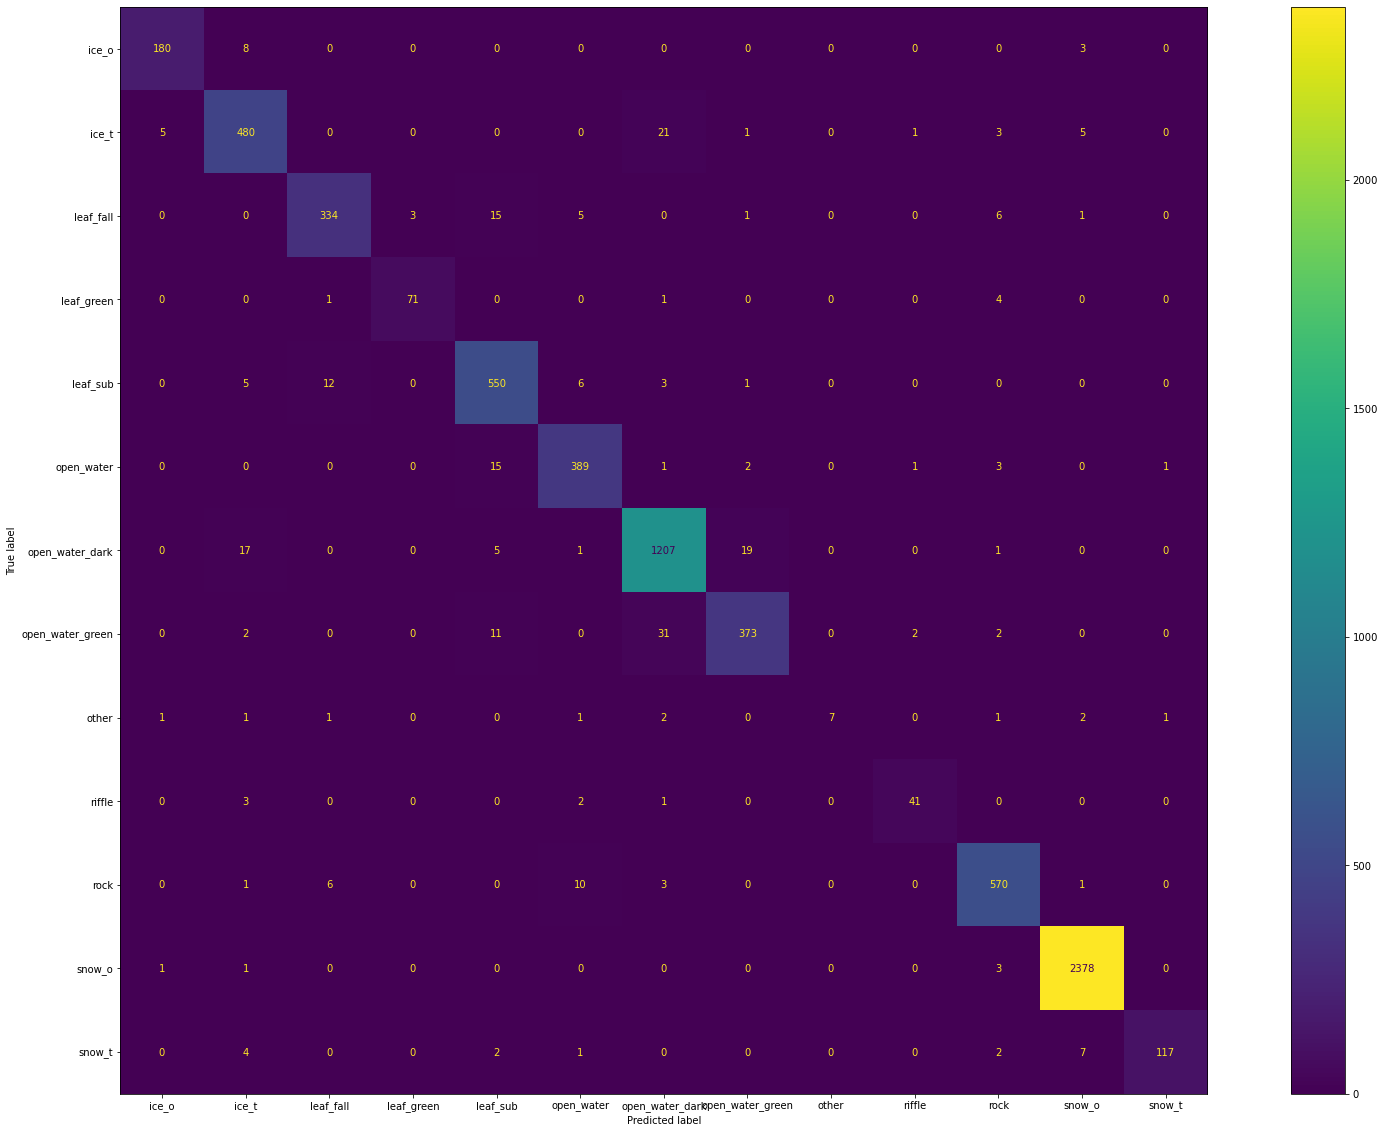

In [45]:
rf_pred = best_rf_grid_2.predict(X_test)
plot_cm(y_test, rf_pred)

In [46]:
print(classification_report(y_test,rf_pred))

                  precision    recall  f1-score   support

           ice_o       0.96      0.94      0.95       191
           ice_t       0.92      0.93      0.92       516
       leaf_fall       0.94      0.92      0.93       365
      leaf_green       0.96      0.92      0.94        77
        leaf_sub       0.92      0.95      0.94       577
      open_water       0.94      0.94      0.94       412
 open_water_dark       0.95      0.97      0.96      1250
open_water_green       0.94      0.89      0.91       421
           other       1.00      0.41      0.58        17
          riffle       0.91      0.87      0.89        47
            rock       0.96      0.96      0.96       591
          snow_o       0.99      1.00      0.99      2383
          snow_t       0.98      0.88      0.93       133

        accuracy                           0.96      6980
       macro avg       0.95      0.89      0.91      6980
    weighted avg       0.96      0.96      0.96      6980



Final Model:
- accuracy of 96% 
- weighted average recall of 96%

In [36]:
# save final model
from joblib import dump, load
dump(best_rf_grid_final, "model.joblib")
# model= load("model.joblib")

In [1]:
from joblib import dump, load

model= load("model.joblib")

In [2]:
dump(model, "model_cop.joblib", compress=9)

['model_cop.joblib']

### Test Model on Unseen Data
- We will use a new data sample which was not used for model training and model testing

In [30]:
# data points that are not in sampled data
ind_array = np.setdiff1d(merged.index,sample_merged.index)

In [41]:
# create test sample data from data points unused for model trainnig and model testing
test_sample = pick_samples(merged.loc[ind_array])

In [42]:
test_sample.describe()

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter
count,34173.000000,34173.000000,34173.000000,34173.000000,34173.000000,34173.000000,34173.00000,34173.000000,34173.000000,34173.000000,34173.000000,34173.000000
mean,1229.538788,1729.130512,131.752261,121.442864,128.541509,36.054575,2018.98215,24.477863,6.108185,0.367337,0.106575,0.526088
std,376.883822,327.228595,78.485869,79.734538,93.283229,12.327823,0.67875,19.982345,4.593180,0.482086,0.308577,0.499326
min,47.000000,1235.000000,0.000000,0.000000,0.000000,12.000000,2018.00000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1037.000000,1439.000000,59.000000,47.000000,38.000000,28.000000,2019.00000,6.000000,2.000000,0.000000,0.000000,0.000000
50%,1268.000000,1608.000000,125.000000,111.000000,105.000000,33.000000,2019.00000,13.000000,4.000000,0.000000,0.000000,1.000000
75%,1489.000000,2074.000000,202.000000,194.000000,230.000000,43.000000,2019.00000,47.000000,11.000000,1.000000,0.000000,1.000000
max,1997.000000,2337.000000,255.000000,255.000000,255.000000,98.000000,2020.00000,52.000000,12.000000,1.000000,1.000000,1.000000


In [43]:
test_sample.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class,year,week,month,season_autumn,season_spring,season_winter
1,1403,1266,192,177,218,2019-01-01,2022-07-19 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
162,1407,1295,186,175,215,2019-01-01,2022-07-19 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
323,1412,1291,194,183,223,2019-01-01,2022-07-19 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
484,1417,1287,187,179,218,2019-01-01,2022-07-19 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
645,1422,1283,185,179,217,2019-01-01,2022-07-19 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1


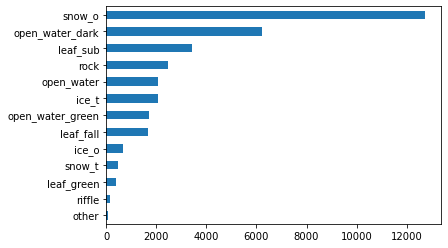

In [47]:
# expected similar distribution of class
test_sample["class"].value_counts().sort_values(ascending=True).plot(kind="barh");

In [49]:
# subset data with desired features/ columns
test_sample = test_sample[
    ['x', 'y', 'R', 'G', 'B',  'temperature', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter',"class"]]
# split data to features and labels
test_sample_features=test_sample.drop("class", axis=1)
test_sample_labels =test_sample["class"]

In [28]:
# predict result of sample test data with our model
sample_predict = model.predict(test_sample_features)

In [ ]:
# evaluate prediction result
print(classification_report(test_sample_labels,sample_predict))

                  precision    recall  f1-score   support

           ice_o       0.99      0.98      0.99       636
           ice_t       0.98      0.98      0.98      1702
       leaf_fall       0.98      0.97      0.98      1217
      leaf_green       0.99      0.98      0.98       256
        leaf_sub       0.98      0.99      0.98      1922
      open_water       0.98      0.98      0.98      1372
 open_water_dark       0.98      0.99      0.99      4098
open_water_green       0.98      0.97      0.97      1405
           other       1.00      0.83      0.91        58
          riffle       0.97      0.96      0.97       158
            rock       0.99      0.99      0.99      1969
          snow_o       1.00      1.00      1.00      7829
          snow_t       1.00      0.96      0.98       442

        accuracy                           0.99     23064
       macro avg       0.99      0.97      0.98     23064
    weighted avg       0.99      0.99      0.99     23064



Result of model on unseen new data sample:

- Accuracy: 99%
- Average Recall: 99%

# Visualizing the result of our model's prediction

In [ ]:
pip install colordict

In [56]:
# use this module to get rgb values of colors
from colordict import ColorDict
colors = ColorDict()

In [37]:
# dictionary of class to color
class_rgb = {'snow_o': "white",
 'open_water_dark': "gray",
 'ice_t': "brown",
 'rock': "orange",
 'leaf_fall': "red",
 'snow_t': "blueviolet",
 'leaf_sub': "green",
 'other': "pink",
 'ice_o': "darkgrey",
 'leaf_green': "gold",
 'open_water': "indigo",
 'riffle': "magenta",
 'open_water_green': "rose"}

In [38]:
# updated dictionary
class_rgb = {'snow_o': "white",
'open_water_dark': "royalblue",
'ice_t': "gray",
'rock': "purple",
'leaf_fall': "orange",
'snow_t': "blueviolet",
'leaf_sub': "goldenrod",
'other': "pink",
'ice_o': "darkgrey",
'leaf_green': "forestgreen",
'open_water': "indigo",
'riffle': "magenta",
'open_water_green': "rose"}

In [46]:
# desired column list
li = ['x', 'y', 'R', 'G', 'B', 'temperature', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter']
def display_predict_img(file):
    img= np.asarray(Image.open("invert_"+file))
    img_cp = img.copy()
    ind =np.where((img[:,:,0]!=0) & (img[:,:,1]!=0) & (img[:,:,2]!=0))
    y_vals = ind[0]
    x_vals = ind[1]
    _= img[y_vals,x_vals,:]
    r_vals, g_vals, b_vals = _[:,0], _[:,1], _[:,2]
    fl = merged[merged.orig_name==file][li]
    point = pd.DataFrame({'x': x_vals,
     'y': y_vals,
     'R': r_vals,
     'G': g_vals,
     'B': b_vals,
    })
    point['temperature']= fl.temperature.values[0]
    point['year']= fl.year.values[0]
    point['week']= fl.week.values[0]
    point['month']= fl.month.values[0]
    point['season_autumn']= fl.season_autumn.values[0]
    point['season_spring']= fl.season_spring.values[0]
    point['season_winter']= fl.season_winter.values[0]
    
    pr = model.predict(point)
    point["pred_class"] = pr
    def apply_change(row):
        pred = row["pred_class"]
        newR, newG, newB=colors[class_rgb[pred]]
        img_cp[row.y,row.x,:] = [newR, newG,newB]
    point.apply(lambda x: apply_change(x), axis=1)
    f, ax = plt.subplots(1,2)
    ax[0].imshow(img)
    ax[1].imshow(img_cp)
    f.set_figheight(15)
    f.set_figwidth(15)

    return img, img_cp, point

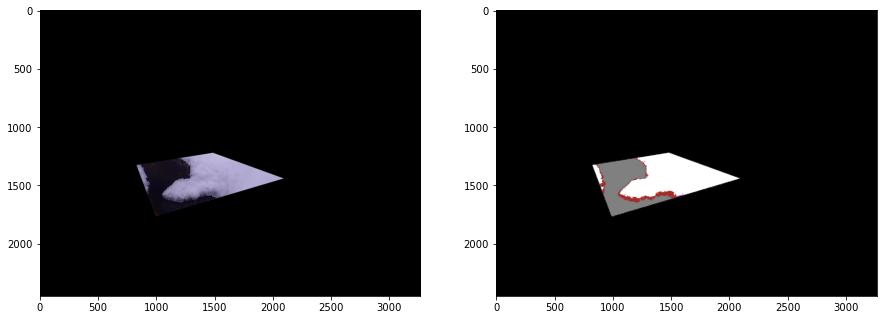

In [66]:
img, img_cp, point= display_predict_img("Hbwtr_w6_20190101_115947.JPG")

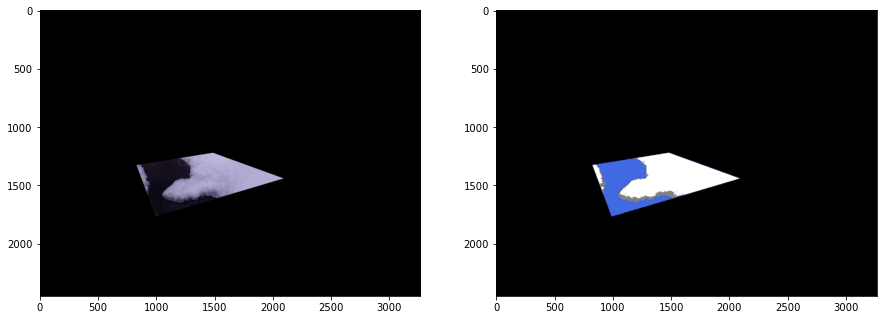

In [68]:
# modified color map
img, img_cp, point= display_predict_img("Hbwtr_w6_20190101_115947.JPG")

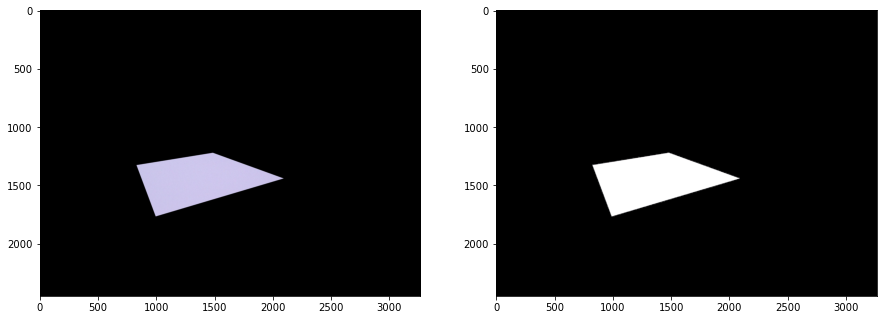

In [154]:
img_2_2, img_cp_2, point_2= display_predict_img("Hbwtr_w6_20190224_120101.JPG")

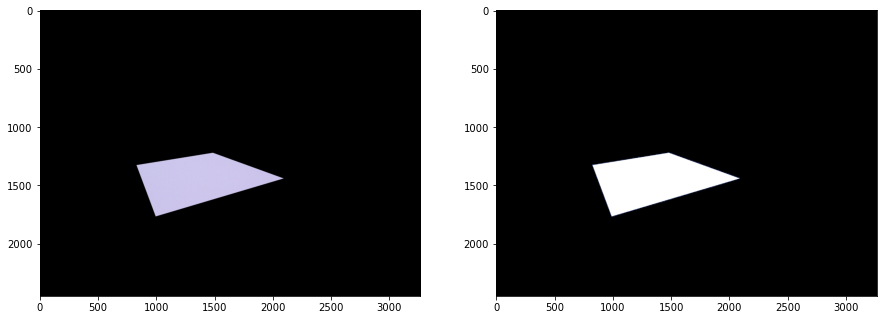

In [69]:
# modified color map
img_2_2, img_cp_2, point_2= display_predict_img("Hbwtr_w6_20190224_120101.JPG")

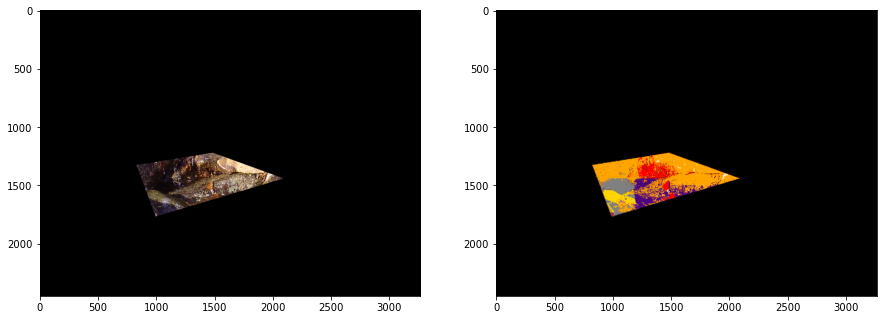

In [189]:
img_2_4, img_cp_4, point_4= display_predict_img("Hbwtr_w6_20191211_115931.JPG")

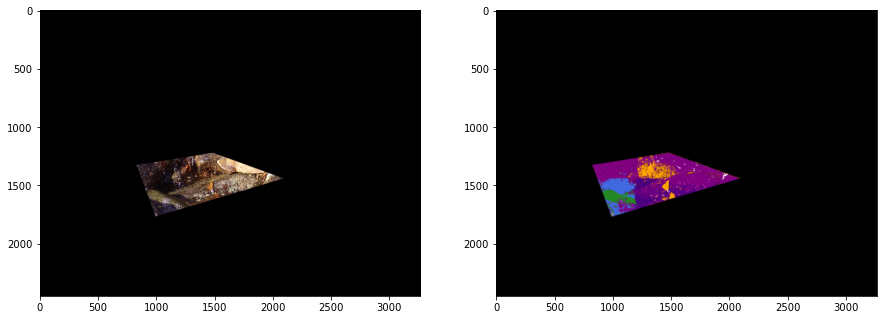

In [70]:
# modified color map
img_2_4, img_cp_4, point_4= display_predict_img("Hbwtr_w6_20191211_115931.JPG")

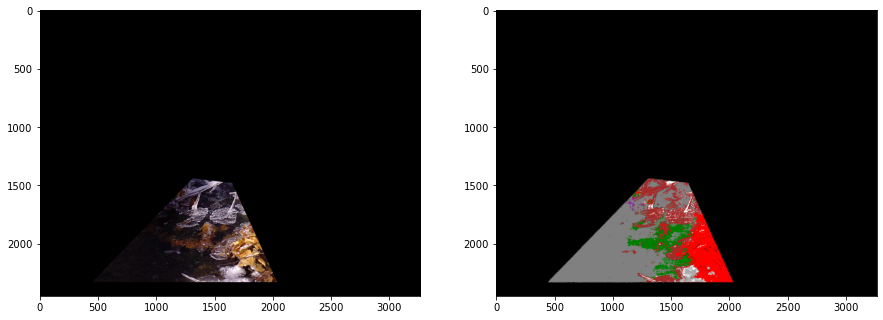

In [192]:
img_2_5, img_cp_5, point_5= display_predict_img("Hbwtr_w6_20181205_115912.JPG")

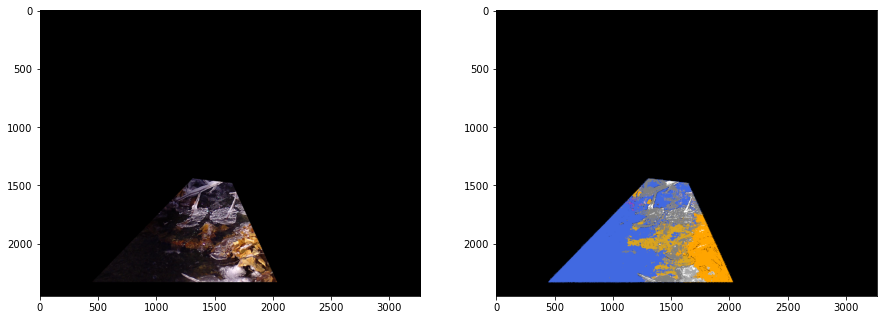

In [ ]:
# modified color map
img_2_5, img_cp_5, point_5= display_predict_img("Hbwtr_w6_20181205_115912.JPG")

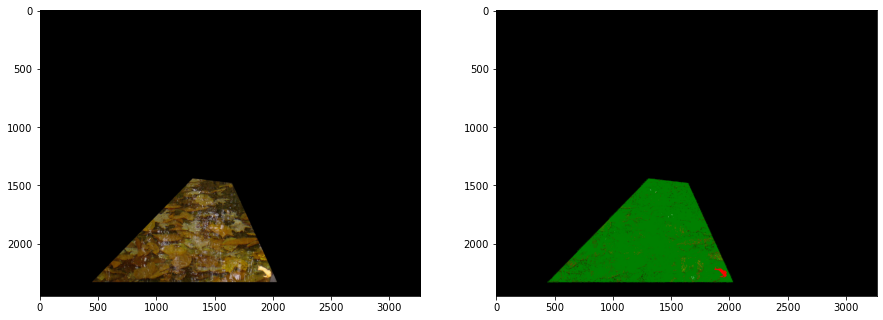

In [ ]:
img_2_6, img_cp_6, point_6= display_predict_img("Hbwtr_w6_20181031_115902.JPG")

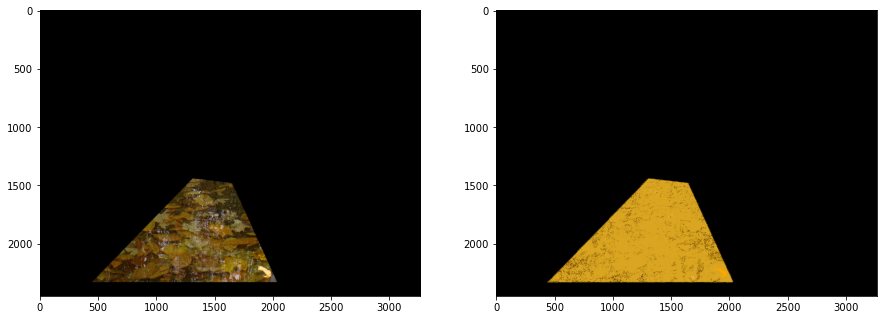

In [72]:
# modified color map
img_2_6, img_cp_6, point_6= display_predict_img("Hbwtr_w6_20181031_115902.JPG")

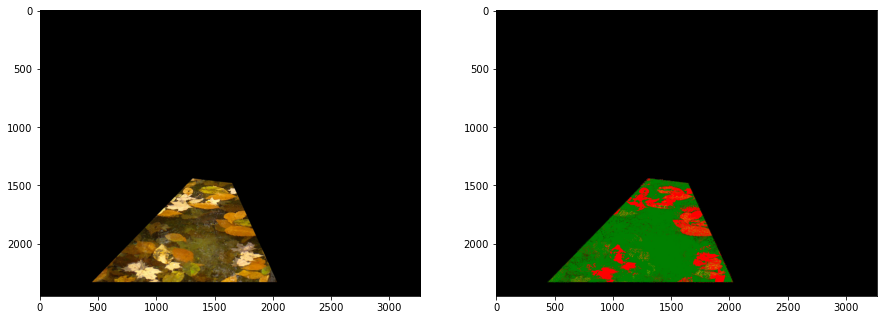

In [195]:
img_2_7, img_cp_7, point_7= display_predict_img("Hbwtr_w6_20181023_115928.JPG")

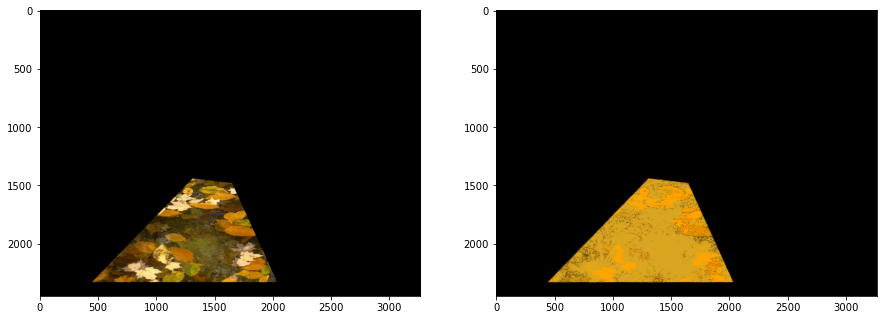

In [73]:
# modified color map
img_2_7, img_cp_7, point_7= display_predict_img("Hbwtr_w6_20181023_115928.JPG")

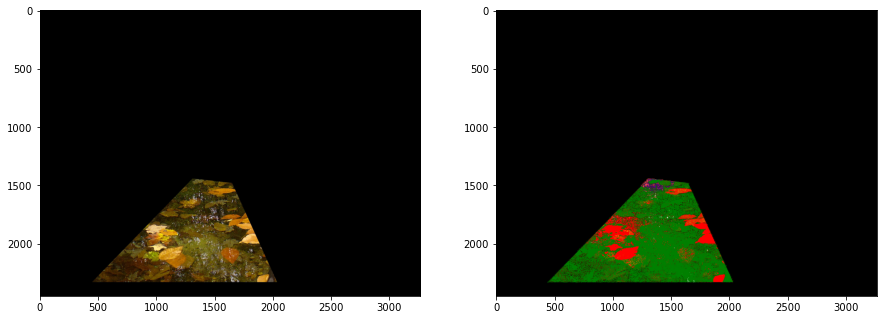

In [196]:
img_2_8, img_cp_8, point_8= display_predict_img("Hbwtr_w6_20181021_115934.JPG")

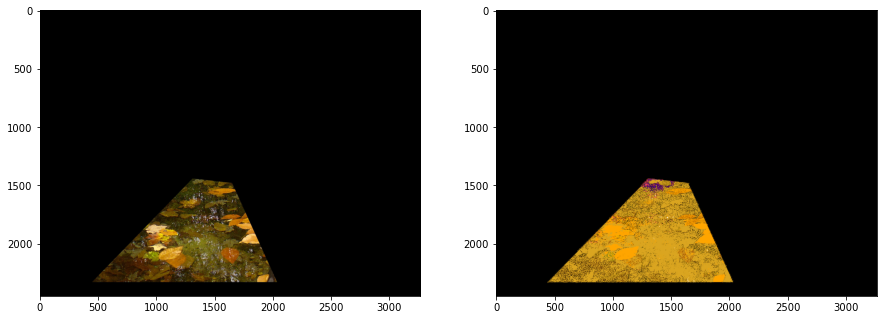

In [74]:
# modified color map
img_2_8, img_cp_8, point_8= display_predict_img("Hbwtr_w6_20181021_115934.JPG")